In [1]:
import numpy as np
import pandas as pd
import os
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Data path is assumed to be 'data' under repo root
def csv_loader(filename, datapath = "./data", stats = True):
    print('Loading %s.' % filename)
    path = os.path.join(datapath, filename)
    try:
        with open(path, 'rb') as f:
              data = pd.read_csv(f)
    except Exception as e:
        print('Unable to load data ', path, ':', e)
    if stats:
        print("{:d} rows of data loaded.".format(len(data)))
    return data

# Data

## Application

In [3]:
df_train = csv_loader("application_train.csv")
df_train.head(3)

Loading application_train.csv.
307511 rows of data loaded.


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
col_categorical = [col for col in df_train.columns if df_train[col].dtype == 'object']

print("{:d} data, {:d} columns, {:d} catagorical".format(len(df_train), len(df_train.columns), len(col_categorical)))

307511 data, 122 columns, 16 catagorical


In [5]:
for col in df_train.columns:
    print("{:40s}".format(col), df_train[col].dtype)

SK_ID_CURR                               int64
TARGET                                   int64
NAME_CONTRACT_TYPE                       object
CODE_GENDER                              object
FLAG_OWN_CAR                             object
FLAG_OWN_REALTY                          object
CNT_CHILDREN                             int64
AMT_INCOME_TOTAL                         float64
AMT_CREDIT                               float64
AMT_ANNUITY                              float64
AMT_GOODS_PRICE                          float64
NAME_TYPE_SUITE                          object
NAME_INCOME_TYPE                         object
NAME_EDUCATION_TYPE                      object
NAME_FAMILY_STATUS                       object
NAME_HOUSING_TYPE                        object
REGION_POPULATION_RELATIVE               float64
DAYS_BIRTH                               int64
DAYS_EMPLOYED                            int64
DAYS_REGISTRATION                        float64
DAYS_ID_PUBLISH                        

In [6]:
col_int = [col for col in df_train.columns if df_train[col].dtype == 'int64']
df_train[col_int].isnull().sum(axis=0)

SK_ID_CURR                     0
TARGET                         0
CNT_CHILDREN                   0
DAYS_BIRTH                     0
DAYS_EMPLOYED                  0
DAYS_ID_PUBLISH                0
FLAG_MOBIL                     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
FLAG_EMAIL                     0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
HOUR_APPR_PROCESS_START        0
REG_REGION_NOT_LIVE_REGION     0
REG_REGION_NOT_WORK_REGION     0
LIVE_REGION_NOT_WORK_REGION    0
REG_CITY_NOT_LIVE_CITY         0
REG_CITY_NOT_WORK_CITY         0
LIVE_CITY_NOT_WORK_CITY        0
FLAG_DOCUMENT_2                0
FLAG_DOCUMENT_3                0
FLAG_DOCUMENT_4                0
FLAG_DOCUMENT_5                0
FLAG_DOCUMENT_6                0
FLAG_DOCUMENT_7                0
FLAG_DOCUMENT_8                0
FLAG_DOCUMENT_9                0
FLAG_DOCUMENT_10               0
FLAG_DOCUM

In [7]:
df_train[col_int].describe(include="all")

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,-16036.995067,63815.045904,-2994.202373,0.999997,0.819889,0.199368,0.998133,...,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335
std,102790.175348,0.272419,0.722121,4363.988632,141275.766519,1509.450419,0.001803,0.384280,0.399526,0.043164,...,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299
min,100002.000000,0.000000,0.000000,-25229.000000,-17912.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,-19682.000000,-2760.000000,-4299.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,-15750.000000,-1213.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367142.500000,0.000000,1.000000,-12413.000000,-289.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,1.000000,19.000000,-7489.000000,365243.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
col_num = [col for col in df_train.columns if df_train[col].dtype == 'float64']
df_train[col_num].isnull().sum(axis=0)

AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
REGION_POPULATION_RELATIVE           0
DAYS_REGISTRATION                    0
OWN_CAR_AGE                     202929
CNT_FAM_MEMBERS                      2
EXT_SOURCE_1                    173378
EXT_SOURCE_2                       660
EXT_SOURCE_3                     60965
APARTMENTS_AVG                  156061
BASEMENTAREA_AVG                179943
YEARS_BEGINEXPLUATATION_AVG     150007
YEARS_BUILD_AVG                 204488
COMMONAREA_AVG                  214865
ELEVATORS_AVG                   163891
ENTRANCES_AVG                   154828
FLOORSMAX_AVG                   153020
FLOORSMIN_AVG                   208642
LANDAREA_AVG                    182590
LIVINGAPARTMENTS_AVG            210199
LIVINGAREA_AVG                  154350
NONLIVINGAPARTMENTS_AVG         213514
NONLIVINGAREA_AVG               169682
APARTMENTS_MODE          

In [9]:
df_train[col_num].describe(include="all")

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,104582.000000,307509.000000,134133.000000,3.068510e+05,...,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-4986.120328,12.061091,2.152665,0.502130,5.143927e-01,...,0.143421,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,3522.886321,11.944812,0.910682,0.211062,1.910602e-01,...,0.446698,2.379803,0.362291,826.808487,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-24672.000000,0.000000,1.000000,0.014568,8.173617e-08,...,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-7479.500000,5.000000,2.000000,0.334007,3.924574e-01,...,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-4504.000000,9.000000,2.000000,0.505998,5.659614e-01,...,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-2010.000000,15.000000,3.000000,0.675053,6.636171e-01,...,0.000000,2.000000,0.000000,-274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,0.000000,91.000000,20.000000,0.962693,8.549997e-01,...,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [10]:
df_train[col_categorical].isnull().sum(axis=0)

NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
OCCUPATION_TYPE                96391
WEEKDAY_APPR_PROCESS_START         0
ORGANIZATION_TYPE                  0
FONDKAPREMONT_MODE            210295
HOUSETYPE_MODE                154297
WALLSMATERIAL_MODE            156341
EMERGENCYSTATE_MODE           145755
dtype: int64

In [11]:
df_train[col_categorical].describe(include="all")

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


## Add Bureau Features

In [12]:
df_bureau = csv_loader("bureau_features.csv", datapath = "./features/")
df_bureau.head(3)

Loading bureau_features.csv.
356255 rows of data loaded.


,SK_ID_CURR,train_test,count_bureau,no_bureau,large_bureau_count,"('DAYS_CREDIT', 'mean')","('DAYS_CREDIT', 'max')","('DAYS_CREDIT', 'min')","('DAYS_CREDIT', 'std')",DAYS_CREDIT,DAYS_CREDIT_mainb,max_overdue,has_overdue,Consumer credit,Credit card,Interbank credit,Loan,Mortgage
0,100002,train,8.0,False,False,-874.00,-103.0,-1437.0,431.451040,-103.0,-103.0,0.0,False,4.0,4.0,0.0,0.0,0.0
1,100003,train,4.0,False,False,-1400.75,-606.0,-2586.0,909.826128,-606.0,-606.0,0.0,False,2.0,2.0,0.0,0.0,0.0
2,100004,train,2.0,False,False,-867.00,-408.0,-1326.0,649.124025,-408.0,-408.0,0.0,False,2.0,0.0,0.0,0.0,0.0


In [13]:
df_train = df_train.merge(df_bureau, on = "SK_ID_CURR", how = "left")
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,"('DAYS_CREDIT', 'std')",DAYS_CREDIT,DAYS_CREDIT_mainb,max_overdue,has_overdue,Consumer credit,Credit card,Interbank credit,Loan,Mortgage
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,431.451040,-103.0,-103.0,0.0,False,4.0,4.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,909.826128,-606.0,-606.0,0.0,False,2.0,2.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,649.124025,-408.0,-408.0,0.0,False,2.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,-1149.0,-1149.0,0.0,False,1.0,0.0,0.0,0.0,0.0


In [14]:
for col in df_bureau.columns:
    print("{:40s}".format(col), df_bureau[col].dtype)

SK_ID_CURR                               int64
train_test                               object
count_bureau                             float64
no_bureau                                bool
large_bureau_count                       bool
('DAYS_CREDIT', 'mean')                  float64
('DAYS_CREDIT', 'max')                   float64
('DAYS_CREDIT', 'min')                   float64
('DAYS_CREDIT', 'std')                   float64
DAYS_CREDIT                              float64
DAYS_CREDIT_mainb                        float64
max_overdue                              float64
has_overdue                              object
Consumer credit                          float64
Credit card                              float64
Interbank credit                         float64
Loan                                     float64
Mortgage                                 float64


In [15]:
col_categorical += [col for col in df_bureau.columns if df_bureau[col].dtype != "int64" and df_bureau[col].dtype != "float64"]
col_categorical

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'train_test',
 'no_bureau',
 'large_bureau_count',
 'has_overdue']

# Model

In [16]:
all_categorical_feats = list(set(col_categorical + [col for col in df_train.columns if col[:4] == "FLAG"]))
all_categorical_feats

['WALLSMATERIAL_MODE',
 'CODE_GENDER',
 'has_overdue',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_11',
 'NAME_INCOME_TYPE',
 'EMERGENCYSTATE_MODE',
 'FLAG_DOCUMENT_6',
 'NAME_TYPE_SUITE',
 'OCCUPATION_TYPE',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_18',
 'ORGANIZATION_TYPE',
 'NAME_CONTRACT_TYPE',
 'FLAG_OWN_REALTY',
 'FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_16',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'no_bureau',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_4',
 'train_test',
 'FLAG_OWN_CAR',
 'FONDKAPREMONT_MODE',
 'FLAG_PHONE',
 'FLAG_DOCUMENT_3',
 'FLAG_WORK_PHONE',
 'large_bureau_count',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_17',
 'FLAG_EMAIL',
 'NAME_HOUSING_TYPE',
 'FLAG_EMP_PHONE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_MOBIL',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_21',
 'HOUSETYPE_MODE',
 'FLAG_DOCUMENT_10']

In [19]:
df_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,"('DAYS_CREDIT', 'min')","('DAYS_CREDIT', 'std')",DAYS_CREDIT,DAYS_CREDIT_mainb,max_overdue,Consumer credit,Credit card,Interbank credit,Loan,Mortgage
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,263491.000000,227419.000000,263491.000000,263491.000000,263491.000000,263491.000000,263491.00000,263491.000000,263491.000000,263491.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,-1762.374882,614.802762,-489.297817,-489.297817,4.772759,4.059380,1.30499,0.000004,0.137591,0.059232
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,863.862181,335.459760,537.574145,537.574145,89.141274,3.497836,1.50277,0.001948,0.613063,0.260005
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,-2922.000000,0.000000,-2922.000000,-2922.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,-2583.000000,353.405534,-620.000000,-620.000000,0.000000,2.000000,0.00000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,-1827.000000,620.569550,-300.000000,-300.000000,0.000000,3.000000,1.00000,0.000000,0.000000,0.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,-1035.000000,849.796436,-143.000000,-143.000000,0.000000,6.000000,2.00000,0.000000,0.000000,0.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,0.000000,2042.831491,0.000000,0.000000,2792.000000,86.000000,22.00000,1.000000,79.000000,13.000000


In [ ]:
exclude_feats = ["train_test"]

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc, average_precision_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score

for col in all_categorical_feats:
    df_train[col] = df_train[col].astype('category') 
X = df_train.drop(['TARGET', 'SK_ID_CURR'] + exclude_feats, axis=1) 
Y = df_train['TARGET']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=123, stratify=Y)

In [18]:
estimator = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced', silent=False)
param_grid = {
    'n_estimators': [200],
    'max_depth':[5],
    'max_delta_step':[0,2],
    'learning_rate': [0.1,0.2,0.3] 
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
gbm = GridSearchCV(estimator, param_grid,  cv=kfold,  verbose=100, scoring=['f1','roc_auc'], refit='roc_auc')
grid_result = gbm.fit(X_train, Y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] learning_rate=0.1, max_delta_step=0, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.2718026401211859, roc_auc=0.752273553610627, total=   8.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s remaining:    0.0s
[CV] learning_rate=0.1, max_delta_step=0, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.28085751407535725, roc_auc=0.7610534798197153, total=  10.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.3s remaining:    0.0s
[CV] learning_rate=0.1, max_delta_step=0, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.2750242954324587, roc_auc=0.7590819797837572, total=  10.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   41.1s remaining:    0.0s
[CV] learning_rate=0.1, max_delta_step=0, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.27492792253712667, roc_auc=0.7560586890964648, total=  11.3s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   57.3s remaining:    0.0s
[CV] learning_rate=0.1, max_delta_step=0, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.2740936271076873, roc_auc=0.756298951267286, total=  10.8s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[CV] learning_rate=0.1, max_delta_step=2, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.27115520138775956, roc_auc=0.7510412095368442, total=  10.3s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.5min remaining:    0.0s
[CV] learning_rate=0.1, max_delta_step=2, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.27893110737709365, roc_auc=0.7594669151003743, total=  10.2s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.7min remaining:    0.0s
[CV] learning_rate=0.1, max_delta_step=2, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.2771357598012745, roc_auc=0.7596436218686677, total=  11.1s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.0min remaining:    0.0s
[CV] learning_rate=0.1, max_delta_step=2, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.2771470476397414, roc_auc=0.7561142138550297, total=   9.9s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.2min remaining:    0.0s
[CV] learning_rate=0.1, max_delta_step=2, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.2731419372149182, roc_auc=0.7563340418014207, total=  10.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.4min remaining:    0.0s
[CV] learning_rate=0.2, max_delta_step=0, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.2, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.2769016697588126, roc_auc=0.7446063022630891, total=  10.1s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:  2.7min remaining:    0.0s
[CV] learning_rate=0.2, max_delta_step=0, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.2, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.2805549185966521, roc_auc=0.7511046983984063, total=  11.5s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  3.0min remaining:    0.0s
[CV] learning_rate=0.2, max_delta_step=0, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.2, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.27974995698801397, roc_auc=0.7517948210990086, total=  11.3s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:  3.2min remaining:    0.0s
[CV] learning_rate=0.2, max_delta_step=0, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.2, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.2757380662374572, roc_auc=0.7458854233498159, total=  10.9s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:  3.5min remaining:    0.0s
[CV] learning_rate=0.2, max_delta_step=0, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.2, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.2746016334456565, roc_auc=0.7493339979159875, total=  11.5s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  3.8min remaining:    0.0s
[CV] learning_rate=0.2, max_delta_step=2, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.2, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.27312521598894135, roc_auc=0.7462771347253012, total=  10.6s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  4.0min remaining:    0.0s
[CV] learning_rate=0.2, max_delta_step=2, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.2, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.28087001198835415, roc_auc=0.7527598952116508, total=  13.6s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:  4.3min remaining:    0.0s
[CV] learning_rate=0.2, max_delta_step=2, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.2, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.27645266969366056, roc_auc=0.749528292119566, total=  12.3s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  4.6min remaining:    0.0s
[CV] learning_rate=0.2, max_delta_step=2, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.2, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.28018709938211006, roc_auc=0.7497418919769524, total=  10.1s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:  4.9min remaining:    0.0s
[CV] learning_rate=0.2, max_delta_step=2, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.2, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.2770850017160508, roc_auc=0.7493983454056126, total=  10.5s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  5.1min remaining:    0.0s
[CV] learning_rate=0.3, max_delta_step=0, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.3, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.2708596903427917, roc_auc=0.7342987636871765, total=  10.1s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  5.4min remaining:    0.0s
[CV] learning_rate=0.3, max_delta_step=0, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.3, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.2763276870215203, roc_auc=0.7403399687710057, total=  10.1s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:  5.6min remaining:    0.0s
[CV] learning_rate=0.3, max_delta_step=0, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.3, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.2760059612518629, roc_auc=0.7414249681442439, total=   9.9s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:  5.8min remaining:    0.0s
[CV] learning_rate=0.3, max_delta_step=0, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.3, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.2757074471308247, roc_auc=0.739266705137114, total=  10.2s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  6.1min remaining:    0.0s
[CV] learning_rate=0.3, max_delta_step=0, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.3, max_delta_step=0, max_depth=5, n_estimators=200, f1=0.273604244543591, roc_auc=0.7378242080911424, total=  10.5s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  6.3min remaining:    0.0s
[CV] learning_rate=0.3, max_delta_step=2, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.3, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.2700126681546722, roc_auc=0.7346976981697441, total=  10.7s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:  6.6min remaining:    0.0s
[CV] learning_rate=0.3, max_delta_step=2, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.3, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.2804056105410164, roc_auc=0.7407100588488199, total=  10.6s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  6.9min remaining:    0.0s
[CV] learning_rate=0.3, max_delta_step=2, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.3, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.2753094540453268, roc_auc=0.7419110703957106, total=  11.1s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:  7.1min remaining:    0.0s
[CV] learning_rate=0.3, max_delta_step=2, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.3, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.27249637155297535, roc_auc=0.7388634144821975, total=  10.3s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:  7.4min remaining:    0.0s
[CV] learning_rate=0.3, max_delta_step=2, max_depth=5, n_estimators=200 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.3, max_delta_step=2, max_depth=5, n_estimators=200, f1=0.2737715763517171, roc_auc=0.7365578316828647, total=  10.3s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.6min finished


# Evaluation

Best: 0.756953 using {'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'n_estimators': 200}
0.756953 (0.002982) with: {'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'n_estimators': 200}
0.756520 (0.003120) with: {'learning_rate': 0.1, 'max_delta_step': 2, 'max_depth': 5, 'n_estimators': 200}
0.748545 (0.002840) with: {'learning_rate': 0.2, 'max_delta_step': 0, 'max_depth': 5, 'n_estimators': 200}
0.749541 (0.002053) with: {'learning_rate': 0.2, 'max_delta_step': 2, 'max_depth': 5, 'n_estimators': 200}
0.738631 (0.002472) with: {'learning_rate': 0.3, 'max_delta_step': 0, 'max_depth': 5, 'n_estimators': 200}
0.738548 (0.002641) with: {'learning_rate': 0.3, 'max_delta_step': 2, 'max_depth': 5, 'n_estimators': 200}


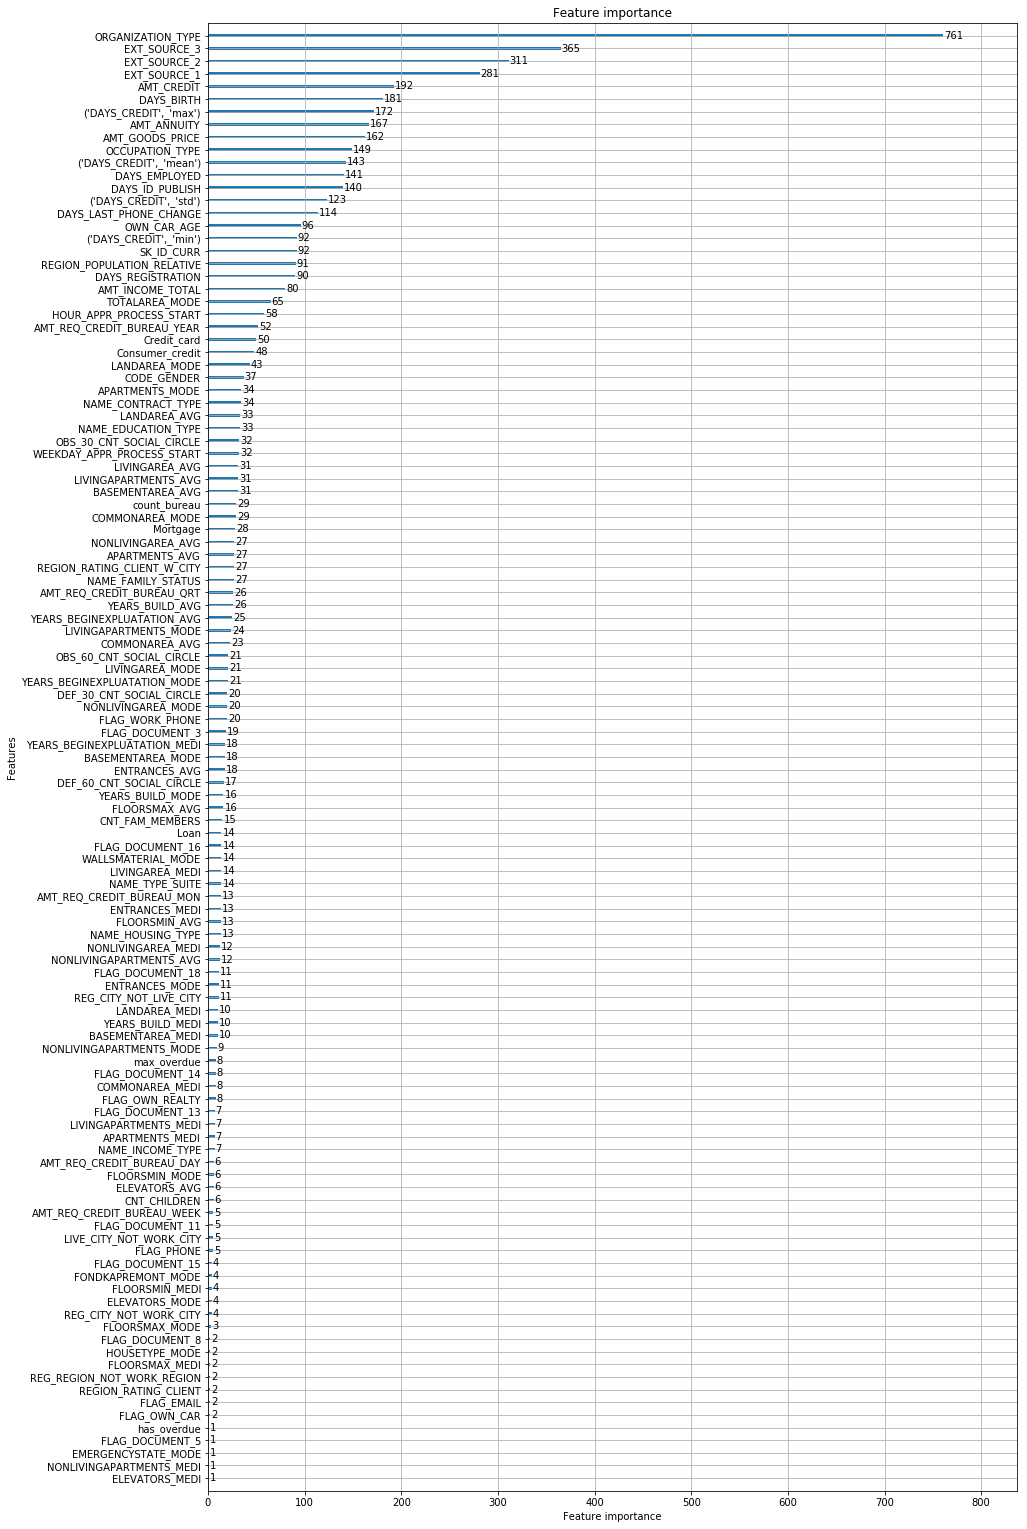

In [19]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_roc_auc']
stds = grid_result.cv_results_['std_test_roc_auc']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

lgb.plot_importance(grid_result.best_estimator_)
plt.gcf().set_size_inches(14.5, 27)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion Matrix:


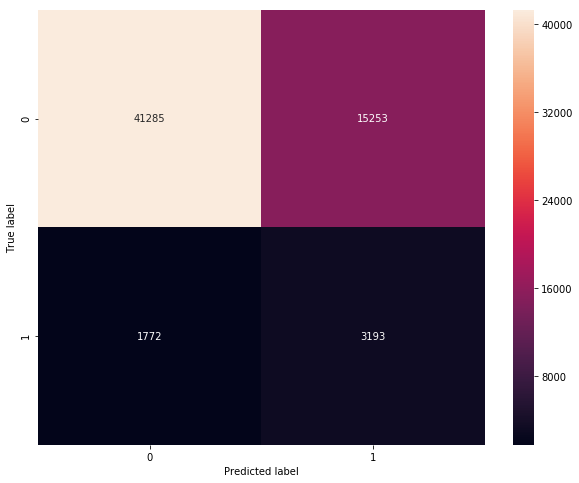

In [20]:
import seaborn as sns

Y_pred = grid_result.predict(X_test)

print('Confusion Matrix:')

df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred))
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_cm, annot=True, fmt="d", ax=ax)
ax.set_ylabel('True label');
ax.set_xlabel('Predicted label');

In [21]:
prob_xgb = pd.DataFrame(list(grid_result.predict_proba(X_test)))
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(Y_test, prob_xgb.iloc[:,1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
p_xgb,r_xgb,thre_xgb = precision_recall_curve(Y_test,prob_xgb.iloc[:,1])
average_p_xgb = average_precision_score(Y_test, prob_xgb.iloc[:,1])

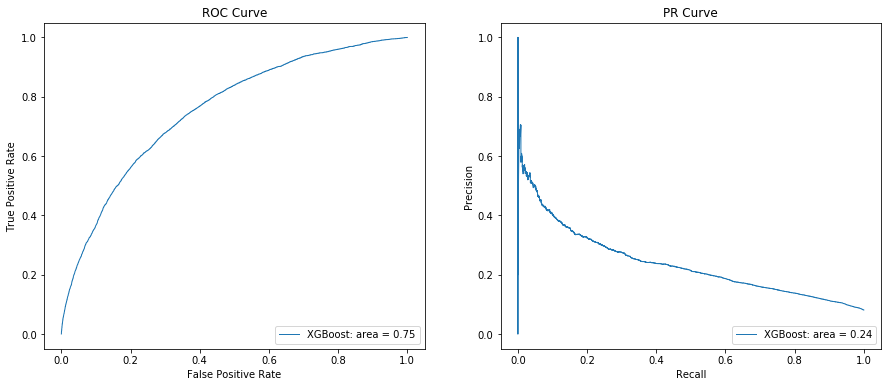

In [22]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('PR Curve')

ax1.plot(fpr_xgb, tpr_xgb, lw=1, label='XGBoost: area = %0.2f'%roc_auc_xgb)

ax2.plot(r_xgb, p_xgb, lw=1, label='XGBoost: area = %0.2f'%average_p_xgb)

ax1.legend(loc='lower right')    
ax2.legend(loc='lower right')

plt.show()

In [23]:
# calculate accuracy for xgboost
score_xgb = grid_result.score(X_test, Y_test)

In [24]:
score_lr = 0
roc_auc_lr = 0
average_p_lr = 0

result = {'Model':['XGBoost'],
          'Binary Accuracy':[score_xgb],
          'AUC of ROC':[roc_auc_xgb],
          'AUC of PR':[average_p_xgb]}
pd.DataFrame(result,columns=['Model', 'Binary Accuracy', 'AUC of ROC', 'AUC of PR'])

,Model,Binary Accuracy,AUC of ROC,AUC of PR
0,XGBoost,0.754714,0.754714,0.237239


# Kaggle

In [25]:
df_test = csv_loader("application_test.csv")
df_test = df_test.merge(df_bureau, on = "SK_ID_CURR", how = "left")
df_test.head(3)

Loading application_test.csv.
48744 rows of data loaded.


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,"('DAYS_CREDIT', 'std')",DAYS_CREDIT,DAYS_CREDIT_mainb,max_overdue,has_overdue,Consumer credit,Credit card,Interbank credit,Loan,Mortgage
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,489.942514,-49.0,-49.0,0.0,False,7.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,162.297053,-62.0,-62.0,0.0,False,2.0,1.0,0.0,0.0,0.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,393.964888,-1210.0,-1210.0,0.0,False,2.0,0.0,0.0,2.0,0.0


In [26]:
for col in all_categorical_feats:
    df_test[col] = df_test[col].astype('category') 

In [27]:
# Refit
best_param = {'learning_rate': 0.1, 'max_delta_step': 2, 'max_depth': 5, 'n_estimators': 200}
est = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced', silent=False, **best_param)

In [28]:
final_model = est.fit(X, Y)
prediction = pd.DataFrame(list(final_model.predict_proba(df_test)))

In [30]:
df_test["TARGET"] = prediction.iloc[:,1]
df_test[["SK_ID_CURR","TARGET"]].to_csv("./results/lgb_model_tva.csv", index = False)